# A Deep Learning approach on Multivariate Short Term Traffic Flow Forecasting
A use case on the traffic models of the Province of Gelderland

### 1. Import Libraries and Packages

In [32]:
import numpy as np
from numpy import savetxt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow import keras

%matplotlib inline
%config InlineBackend.figure_format='retina'
register_matplotlib_converters()
#sns.set(style='whitegrid', palette='muted', font_scale=1.5)
#rcParams['figure.figsize'] = 22, 10

In [33]:
np.random.seed(2009)
tf.random.set_seed(2009)

### 2. Data

#### 2.1 Import Data

In [34]:
source = 'https://raw.githubusercontent.com/jwillekes18/Multivariate-Short-Term-Traffic-Flow-Prediction/main/Dataset_processed.csv'
df = pd.read_csv(source, index_col=0)
df = df[['Intensity', 'Speed_lane1', 'Speed_lane2', 'Sight']]
df.replace("", float("NaN"), inplace=True)
df = df.dropna()
df.head()

,Intensity,Speed_lane1,Speed_lane2,Sight
timestamp,,,,
01/02/2019 06:00,102,63.4,60.2,57
01/02/2019 06:15,135,76.9,67.2,58
01/02/2019 06:30,266,71.5,60.6,58
01/02/2019 06:45,411,75.6,64.5,58
01/02/2019 07:00,596,71.1,62.6,58


#### 2.2 Data Preprocessing

In [35]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

5094 566


In [36]:
features = ['Speed_lane1', 'Speed_lane2', 'Sight']

feature_scaler = MinMaxScaler()
intensity_scaler = MinMaxScaler()

feature_scaler = feature_scaler.fit(train[features].to_numpy())
intensity_scaler = intensity_scaler.fit(train[['Intensity']])

train.loc[:, features] = feature_scaler.transform(train[features].to_numpy())
train['Intensity'] = intensity_scaler.transform(train[['Intensity']])

test.loc[:, features] = feature_scaler.transform(test[features].to_numpy())
test['Intensity'] = intensity_scaler.transform(test[['Intensity']])

/Users/willekes/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-36-89f294edac0e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Intensity'] = intensity_scaler.transform(train[['Intensity']])
/Users/willekes/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [37]:
def training_data(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [38]:
time_steps = 40 #Make predictions on the past 40 time_steps = 10h

# reshape to [samples, time_steps, n_features]

X_train, y_train = training_data(train, train.Intensity, time_steps)
x_test, y_test = training_data(test, test.Intensity, time_steps)

print(X_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5054, 40, 4) (5054,)
(526, 40, 4) (526,)


## 3. Define Neural Network Models

### Vanilla LSTM
Create LSTMs with 1 layer and units hidden neurons

In [39]:
def model_vLSTM(units):
    model = keras.Sequential()
    #input
    model.add(keras.layers.LSTM(
        units=units,
        activation="relu",
        input_shape=(X_train.shape[1], X_train.shape[2])
        ))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

### Traditional LSTMs
Traditional LSTM models with different hidden layers. Input is different number of neurons in hidden layers

In [40]:
def model_tLSTM_h2(units):
    model = keras.Sequential()
    #Input Layer
    model.add(keras.layers.LSTM(
        units=units,
        activation="relu",
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])
        ))
    model.add(keras.layers.Dropout(0.2))
    #Hidden Layer
    model.add(keras.layers.LSTM(
        units=units,
        ))
    model.add(keras.layers.Dropout(0.2))
    #Output Layer
    model.add(keras.layers.Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

In [41]:
def model_tLSTM_h3(units):
    model = keras.Sequential()
    #Input Layer
    model.add(keras.layers.LSTM(
        units=units,
        activation="relu",
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])
        ))
    model.add(keras.layers.Dropout(0.2))
    #Hidden Layers
    model.add(keras.layers.LSTM(
        units=units,
        activation="relu",
        return_sequences=True,
        ))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.LSTM(
        units=units,
        activation="relu",
        ))
    model.add(keras.layers.Dropout(0.2))
    #Output Layer
    model.add(keras.layers.Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

In [42]:
def model_tLSTM_h4(units):
    model = keras.Sequential()
    #input
    model.add(keras.layers.LSTM(
        units=units,
        activation="relu",
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])
        ))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.LSTM(
        units=units,
        activation="relu",
        return_sequences=True,
        ))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.LSTM(
        units=units,
        activation="relu",
        return_sequences=True,
        ))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.LSTM(
        units=units,
        activation="relu",
        ))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

### Bidirectional LSTM

In [43]:
def model_BiLSTM(units):
    model = keras.Sequential()
    #Input Layer
    model.add(keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=units,
            activation="relu",
            input_shape=(X_train.shape[1], X_train.shape[2])
        )))
    model.add(keras.layers.Dropout(0.2))
    #Hidden Layer
    model.add(keras.layers.Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

### GRU network

In [44]:
def model_GRU(units):
    model = keras.Sequential()
    #input
    model.add(keras.layers.GRU(
        units=units,
        activation="relu",
        input_shape=(X_train.shape[1], X_train.shape[2])
        ))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

### Bidirectional GRUs

In [45]:
def model_BiGRU(units):
    model = keras.Sequential()
    #input
    model.add(keras.layers.Bidirectional(
        keras.layers.GRU(
            units=units,
            activation="relu",
            input_shape=(X_train.shape[1], X_train.shape[2])
        )))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

In [46]:
def model_BiGRU_h2(units):
    model = keras.Sequential()
    #input
    model.add(keras.layers.Bidirectional(
        keras.layers.GRU(
            units=units,
            return_sequences=True,
            activation="relu",
            input_shape=(X_train.shape[1], X_train.shape[2])
        )))
    model.add(keras.layers.Dropout(0.2))
    #Hidden Layers
    model.add(keras.layers.Bidirectional(
        keras.layers.GRU(
            units=units,
            activation="relu",
        )))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

## 4. Train Networks

In [47]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        min_delta = 0.0,
        patience = 10)
    history = model.fit(
        X_train, y_train, 
        epochs = 100, 
        validation_split = 0.1,
        batch_size = 64, 
        shuffle = False, 
        callbacks = [early_stop])
    return history

## 5. Processing Results

In [48]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (8, 4))
    plt.plot(history.history['loss'], color = 'blue', label='Train Loss')
    plt.plot(history.history['val_loss'], color = 'red', label='Validation Loss')
    plt.title('Train vs. Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(loc='upper right')
    plt.savefig('Final/n/Loss/'+'Loss_'+model_name+'.jpg', format='jpg', dpi=1000)

In [49]:
def save_model(model, model_name):
    model.save('Final/n/Models/'+model_name)
    return None

In [112]:
def prediction(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_train_inv = intensity_scaler.inverse_transform(y_train.reshape(1, -1))
    y_test_inv = intensity_scaler.inverse_transform(y_test.reshape(1, -1))
    y_pred_inv = intensity_scaler.inverse_transform(y_pred)
    return y_pred, y_pred_inv, y_train_inv, y_test_inv

In [51]:
def plot_forecast(prediction_model, y_test, model_name):
    y_pred, y_pred_inv, y_train_inv, y_test_inv = prediction_model
    plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="Test data")
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="Prediction "+model_name)
    plt.ylabel('Motoervehicles per 15 min')
    plt.xlabel('Time Step')
    plt.title('Forecast Traffic Intensity for '+ model_name)
    plt.legend()
    plt.savefig('Final/n/Forecast/'+'Forecast_'+model_name+'.jpg', format='jpg', dpi=1000)
    plt.show();

In [52]:
def plot_compare(prediction_model ,y_test, model_name):
    
    y_pred, y_pred_inv, y_train_inv, y_test_inv = prediction_model
    plt.plot(y_test_inv.flatten(), marker='.', label="Test data")
    plt.plot(y_pred_inv.flatten(), 'r', label="Prediction "+model_name)
    plt.ylabel('Motorvehicles per 15 min')
    plt.xlabel('Time Step')
    plt.title('Test data vs Prediction data for '+model_name)
    plt.legend()
    plt.savefig('Final/n32/Test vs Prediction/'+'TestPrediction_'+model_name+'.jpg', format='jpg', dpi=1000)
    plt.show();

In [53]:
def plot_compare_models_2(prediction_model_1, prediction_model_2 ,y_test, model_name_1, model_name_2):
    
    y_pred_1, y_pred_inv_1, y_train_inv_1, y_test_inv_1 = prediction_model_1
    y_pred_2, y_pred_inv_2, y_train_inv_2, y_test_inv_2 = prediction_model_2
    
    plt.plot(y_test_inv_1.flatten(), marker='.', label="Test data")
    plt.plot(y_pred_inv_1.flatten(), 'r', label="Prediction "+model_name_1)
    plt.plot(y_pred_inv_2.flatten(), 'g', label="Prediction "+model_name_2)
    plt.ylabel('Motorvehicles per 15 min')
    plt.xlabel('Time Step')
    plt.title('Test data vs Prediction data: '+model_name_1+' vs. '+model_name_2)
    plt.legend()
    plt.savefig('Final/n/Test vs Prediction/'+'TestPrediction_'+model_name_1+'vs'+model_name_2+'.jpg', format='jpg', dpi=1000)
    plt.show();

In [54]:
def plot_compare_models_3(prediction_model_1, prediction_model_2, prediction_model_3, y_test, model_name_1, model_name_2, model_name_3):
    
    y_pred_1, y_pred_inv_1, y_train_inv_1, y_test_inv_1 = prediction_model_1
    y_pred_2, y_pred_inv_2, y_train_inv_2, y_test_inv_2 = prediction_model_2
    y_pred_3, y_pred_inv_3, y_train_inv_3, y_test_inv_3 = prediction_model_3
    
    plt.plot(y_test_inv_1.flatten(), marker='.', label="Test data")
    plt.plot(y_pred_inv_1.flatten(), 'r', label="Prediction "+model_name_1)
    plt.plot(y_pred_inv_2.flatten(), 'g', label="Prediction "+model_name_2)
    plt.plot(y_pred_inv_3.flatten(), 'gray', label="Prediction "+model_name_3)
    
    plt.ylabel('Motorvehicles per 15 min')
    plt.xlabel('Time Step')
    plt.title('Test data vs Prediction data: '+model_name_1+' vs. '+model_name_2 + ' vs. '+model_name_3)
    plt.legend()
    plt.savefig('Final/n/Test vs Prediction/'+'TestPrediction_'+model_name_1+'vs'+model_name_2+'vs'+model_name_3+'.jpg', format='jpg', dpi=1000)
    plt.show();

In [55]:
def evaluate_performance(prediction_model, y_test, model_name):
    y_pred, y_pred_inv, y_train_inv, y_test_inv = prediction_model
    
    y_test_inv = y_test_inv.reshape(-1,1)
    errors = y_pred_inv - y_test_inv
    
    
    mae = round(np.abs(errors).mean(),2)
    mse = round(np.square(errors).mean(),2)
    rmse = round(np.sqrt(mse),2)
    r_sq = round(r2_score(y_test, y_pred),2)
    
    performance = pd.DataFrame({"Model": [model_name], "MAE": [mae], "MSE": [mse], "RMSE": [mse], "R^2": [r_sq]})
    performance.to_csv('Final/n/Measures/'+'Measures_'+model_name+'.csv')
    
    print('Performance of '+model_name+ ':')
    print('MAE:\t', mae)
    print('MSE:\t', mse)
    print('RMSE:\t', rmse)
    print('R^2:\t', r_sq)
    return mae, mse, rmse, r_sq

# 6. Generating Models

### Create Models

Vanilla LSTM Neurons

In [56]:
vLSTM_n4 = model_vLSTM(4)
vLSTM_n8 = model_vLSTM(8)
vLSTM_n16 = model_vLSTM(16)
vLSTM_n32 = model_vLSTM(32)

Traditional LSTM Layers

In [57]:
# LSTM models with 32 hidden neurons.
tLSTM_n32h2 = model_tLSTM_h2(32)
tLSTM_n32h3 = model_tLSTM_h3(32)
tLSTM_n32h4 = model_tLSTM_h4(32)
GRU_n32 = model_GRU(32)
BiLSTM_n32 = model_BiLSTM(32)
BiGRU_n32 = model_BiGRU(32)

### Train Models

In [58]:
history_vLSTM_n4 = fit_model(vLSTM_n4)
history_vLSTM_n8 = fit_model(vLSTM_n8)
history_vLSTM_n16 = fit_model(vLSTM_n16)
history_vLSTM_n32 = fit_model(vLSTM_n32)

Epoch 1/100
72/72 [==============================] - 3s 15ms/step - loss: 0.0783 - val_loss: 0.0332
Epoch 2/100
72/72 [==============================] - 1s 12ms/step - loss: 0.0534 - val_loss: 0.0227
Epoch 3/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0453 - val_loss: 0.0180
Epoch 4/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0408 - val_loss: 0.0156
Epoch 5/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0371 - val_loss: 0.0140
Epoch 6/100
72/72 [==============================] - 1s 12ms/step - loss: 0.0340 - val_loss: 0.0127
Epoch 7/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0298 - val_loss: 0.0121
Epoch 8/100
72/72 [==============================] - 1s 12ms/step - loss: 0.0279 - val_loss: 0.0115
Epoch 9/100
72/72 [==============================] - 1s 12ms/step - loss: 0.0246 - val_loss: 0.0112
Epoch 10/100
72/72 [==============================] - 1s 14ms/step - loss: 0.0248 - val_loss: 0.0108

72/72 [==============================] - 1s 11ms/step - loss: 0.0422 - val_loss: 0.0216
Epoch 5/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0386 - val_loss: 0.0191
Epoch 6/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0329 - val_loss: 0.0171
Epoch 7/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0308 - val_loss: 0.0140
Epoch 8/100
72/72 [==============================] - 1s 12ms/step - loss: 0.0240 - val_loss: 0.0113
Epoch 9/100
72/72 [==============================] - 1s 12ms/step - loss: 0.0230 - val_loss: 0.0097
Epoch 10/100
72/72 [==============================] - 1s 12ms/step - loss: 0.0210 - val_loss: 0.0094
Epoch 11/100
72/72 [==============================] - 1s 12ms/step - loss: 0.0193 - val_loss: 0.0084
Epoch 12/100
72/72 [==============================] - 1s 12ms/step - loss: 0.0186 - val_loss: 0.0080
Epoch 13/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0173 - val_loss: 0.0079
Epoch 14

72/72 [==============================] - 1s 12ms/step - loss: 0.0076 - val_loss: 0.0041
Epoch 86/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0074 - val_loss: 0.0043
Epoch 87/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0076 - val_loss: 0.0041
Epoch 88/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0074 - val_loss: 0.0041
Epoch 89/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0076 - val_loss: 0.0042
Epoch 90/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0072 - val_loss: 0.0041
Epoch 91/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0075 - val_loss: 0.0040
Epoch 92/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0074 - val_loss: 0.0042
Epoch 93/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0070 - val_loss: 0.0041
Epoch 94/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0076 - val_loss: 0.0042
Epo

72/72 [==============================] - 1s 13ms/step - loss: 0.0065 - val_loss: 0.0038
Epoch 67/100
72/72 [==============================] - 1s 12ms/step - loss: 0.0060 - val_loss: 0.0038
Epoch 68/100
72/72 [==============================] - 1s 12ms/step - loss: 0.0061 - val_loss: 0.0037
Epoch 69/100
72/72 [==============================] - 1s 12ms/step - loss: 0.0061 - val_loss: 0.0037
Epoch 70/100
72/72 [==============================] - 1s 12ms/step - loss: 0.0059 - val_loss: 0.0039
Epoch 71/100
72/72 [==============================] - 1s 12ms/step - loss: 0.0060 - val_loss: 0.0040
Epoch 72/100
72/72 [==============================] - 1s 12ms/step - loss: 0.0061 - val_loss: 0.0038
Epoch 73/100
72/72 [==============================] - 1s 12ms/step - loss: 0.0060 - val_loss: 0.0037
Epoch 74/100
72/72 [==============================] - 1s 12ms/step - loss: 0.0060 - val_loss: 0.0037
Epoch 75/100
72/72 [==============================] - 1s 12ms/step - loss: 0.0057 - val_loss: 0.0038
Epo

72/72 [==============================] - 1s 14ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 53/100
72/72 [==============================] - 1s 14ms/step - loss: 0.0054 - val_loss: 0.0038
Epoch 54/100
72/72 [==============================] - 1s 14ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 55/100
72/72 [==============================] - 1s 14ms/step - loss: 0.0051 - val_loss: 0.0035
Epoch 56/100
72/72 [==============================] - 1s 15ms/step - loss: 0.0051 - val_loss: 0.0035
Epoch 57/100
72/72 [==============================] - 1s 14ms/step - loss: 0.0051 - val_loss: 0.0037
Epoch 58/100
72/72 [==============================] - 1s 14ms/step - loss: 0.0052 - val_loss: 0.0035
Epoch 59/100
72/72 [==============================] - 1s 13ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 60/100
72/72 [==============================] - 1s 14ms/step - loss: 0.0051 - val_loss: 0.0036
Epoch 61/100
72/72 [==============================] - 1s 14ms/step - loss: 0.0050 - val_loss: 0.0037
Epo

In [59]:
history_tLSTM_n32h2 = fit_model(tLSTM_n32h2)
history_tLSTM_n32h3 = fit_model(tLSTM_n32h3)
history_tLSTM_n32h4 = fit_model(tLSTM_n32h4)
history_GRU_n32 = fit_model(GRU_n32)
history_BiLSTM_n32 = fit_model(BiLSTM_n32)
history_BiGRU_n32 = fit_model(BiGRU_n32)

Epoch 1/100
72/72 [==============================] - 5s 38ms/step - loss: 0.0562 - val_loss: 0.0332
Epoch 2/100
72/72 [==============================] - 3s 42ms/step - loss: 0.0350 - val_loss: 0.0196
Epoch 3/100
72/72 [==============================] - 4s 49ms/step - loss: 0.0225 - val_loss: 0.0133
Epoch 4/100
72/72 [==============================] - 2s 28ms/step - loss: 0.0181 - val_loss: 0.0100
Epoch 5/100
72/72 [==============================] - 2s 28ms/step - loss: 0.0164 - val_loss: 0.0088
Epoch 6/100
72/72 [==============================] - 2s 29ms/step - loss: 0.0145 - val_loss: 0.0080
Epoch 7/100
72/72 [==============================] - 2s 30ms/step - loss: 0.0137 - val_loss: 0.0077
Epoch 8/100
72/72 [==============================] - 2s 31ms/step - loss: 0.0123 - val_loss: 0.0070
Epoch 9/100
72/72 [==============================] - 2s 29ms/step - loss: 0.0121 - val_loss: 0.0066
Epoch 10/100
72/72 [==============================] - 2s 29ms/step - loss: 0.0113 - val_loss: 0.0064

72/72 [==============================] - 2s 28ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 83/100
72/72 [==============================] - 2s 28ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 84/100
72/72 [==============================] - 2s 28ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 85/100
72/72 [==============================] - 2s 28ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 86/100
72/72 [==============================] - 2s 27ms/step - loss: 0.0044 - val_loss: 0.0035
Epoch 87/100
72/72 [==============================] - 2s 27ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 88/100
72/72 [==============================] - 2s 29ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 89/100
72/72 [==============================] - 2s 28ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 90/100
72/72 [==============================] - 2s 28ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 91/100
72/72 [==============================] - 2s 28ms/step - loss: 0.0042 - val_loss: 0.0034
Epo

72/72 [==============================] - 3s 41ms/step - loss: 0.0053 - val_loss: 0.0043
Epoch 64/100
72/72 [==============================] - 3s 39ms/step - loss: 0.0054 - val_loss: 0.0042
Epoch 65/100
72/72 [==============================] - 3s 39ms/step - loss: 0.0054 - val_loss: 0.0042
Epoch 66/100
72/72 [==============================] - 3s 42ms/step - loss: 0.0052 - val_loss: 0.0045
Epoch 67/100
72/72 [==============================] - 3s 40ms/step - loss: 0.0052 - val_loss: 0.0046
Epoch 68/100
72/72 [==============================] - 3s 43ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 69/100
72/72 [==============================] - 3s 40ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 70/100
72/72 [==============================] - 3s 41ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 71/100
72/72 [==============================] - 3s 40ms/step - loss: 0.0051 - val_loss: 0.0043
Epoch 72/100
72/72 [==============================] - 3s 42ms/step - loss: 0.0048 - val_loss: 0.0043
Epo

72/72 [==============================] - 1s 19ms/step - loss: 0.0082 - val_loss: 0.0044
Epoch 16/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0077 - val_loss: 0.0044
Epoch 17/100
72/72 [==============================] - 1s 17ms/step - loss: 0.0073 - val_loss: 0.0043
Epoch 18/100
72/72 [==============================] - 2s 21ms/step - loss: 0.0074 - val_loss: 0.0042
Epoch 19/100
72/72 [==============================] - 2s 22ms/step - loss: 0.0072 - val_loss: 0.0043
Epoch 20/100
72/72 [==============================] - 2s 22ms/step - loss: 0.0067 - val_loss: 0.0042
Epoch 21/100
72/72 [==============================] - 1s 18ms/step - loss: 0.0069 - val_loss: 0.0042
Epoch 22/100
72/72 [==============================] - 1s 20ms/step - loss: 0.0066 - val_loss: 0.0040
Epoch 23/100
72/72 [==============================] - 2s 22ms/step - loss: 0.0063 - val_loss: 0.0041
Epoch 24/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0064 - val_loss: 0.0040
Epo

KeyboardInterrupt: 

### Save Models

In [ ]:
save_model(vLSTM_n4, 'vLSTM_n4')
save_model(vLSTM_n8, 'vLSTM_n8')
save_model(vLSTM_n16, 'vLSTM_n16')
save_model(vLSTM_n32, 'vLSTM_n32')

In [ ]:
save_model(tLSTM_n32h2, 'tLSTM_n32h2')
save_model(tLSTM_n32h3, 'tLSTM_n32h3')
save_model(tLSTM_n32h4, 'tLSTM_n32h4')
save_model(GRU_n32, 'GRU_n32')
save_model(BiLSTM_n32, 'BiLSTM_n32')
save_model(BiGRU_n32, 'BiGRU_n32')

### Plot Loss Functions

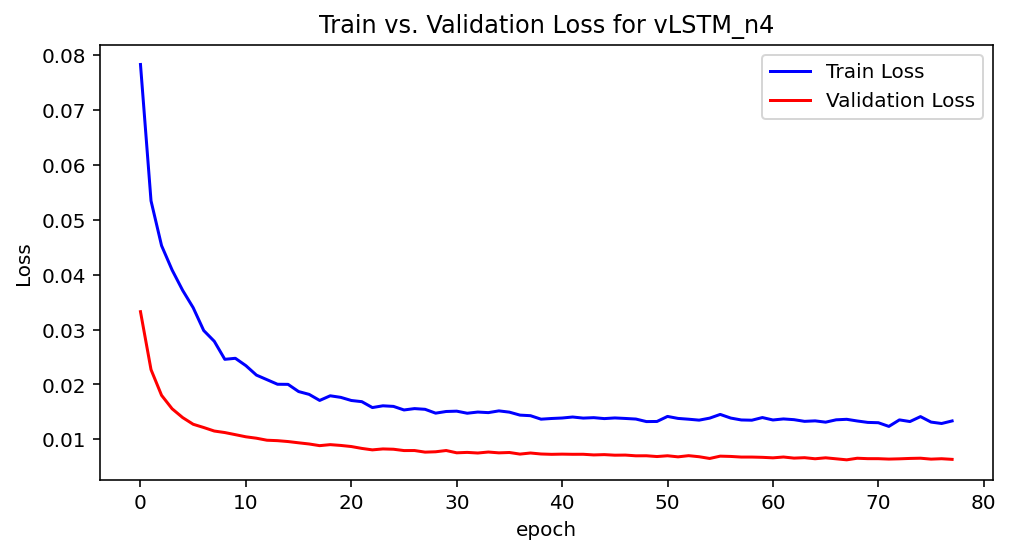

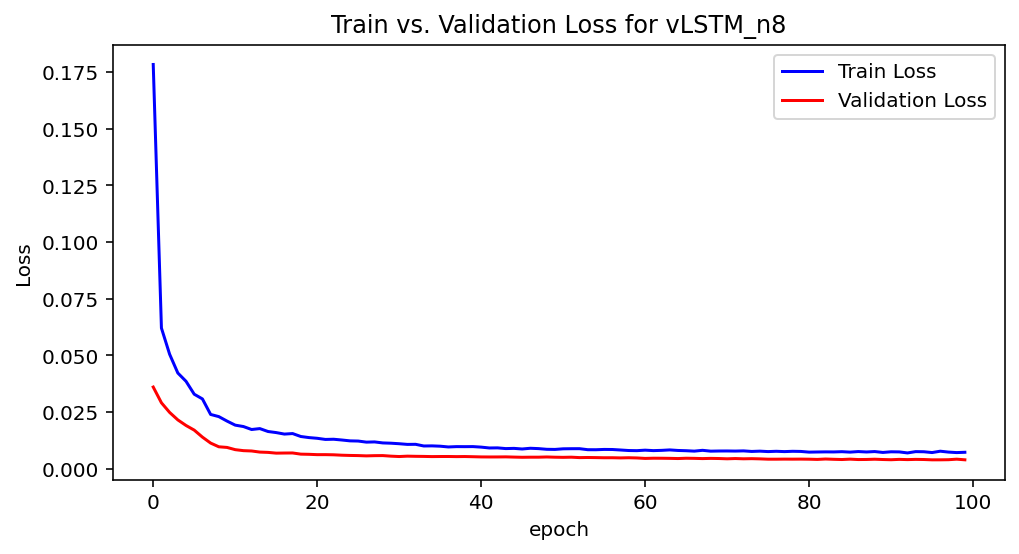

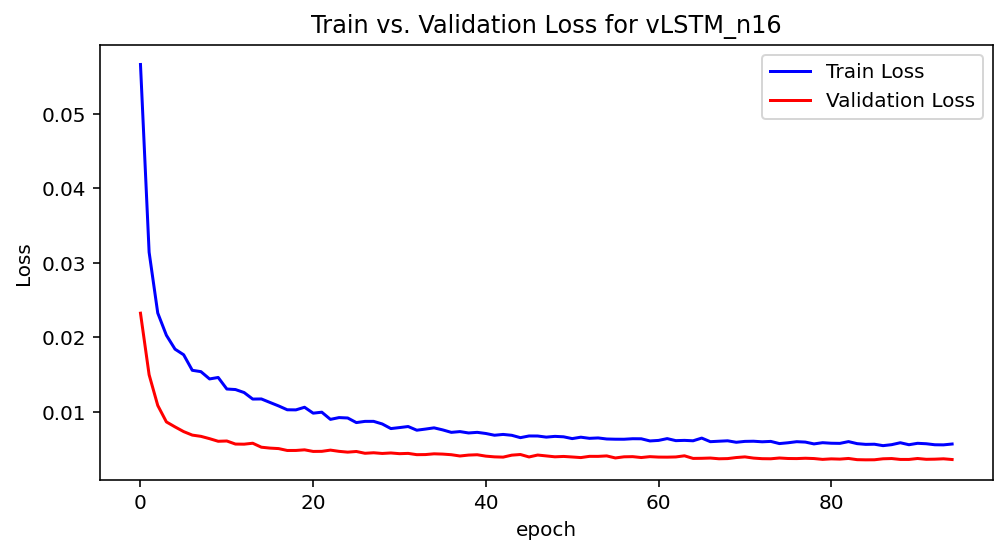

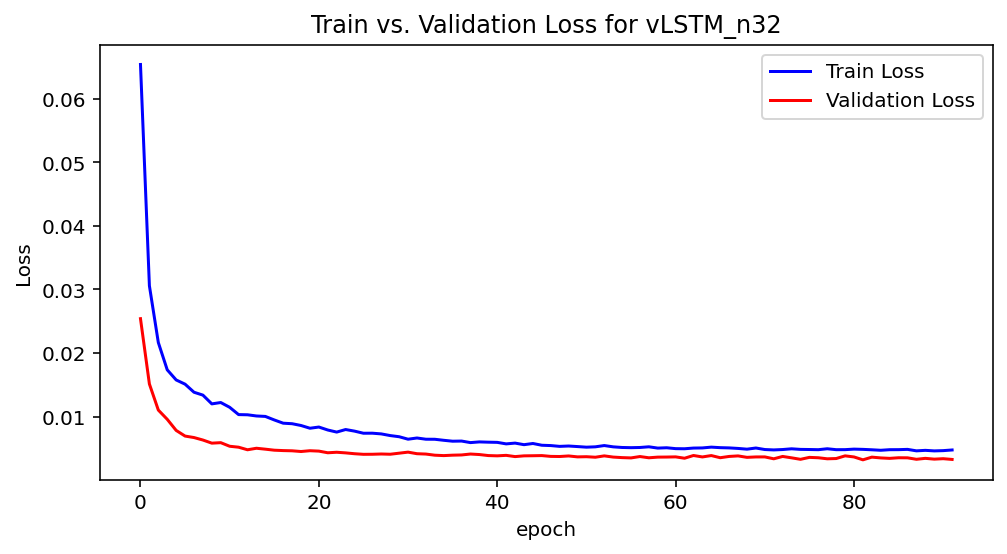

In [60]:
plot_loss(history_vLSTM_n4, 'vLSTM_n4')
plot_loss(history_vLSTM_n8, 'vLSTM_n8')
plot_loss(history_vLSTM_n16, 'vLSTM_n16')
plot_loss(history_vLSTM_n32, 'vLSTM_n32')

NameError: name 'history_GRU_n32' is not defined

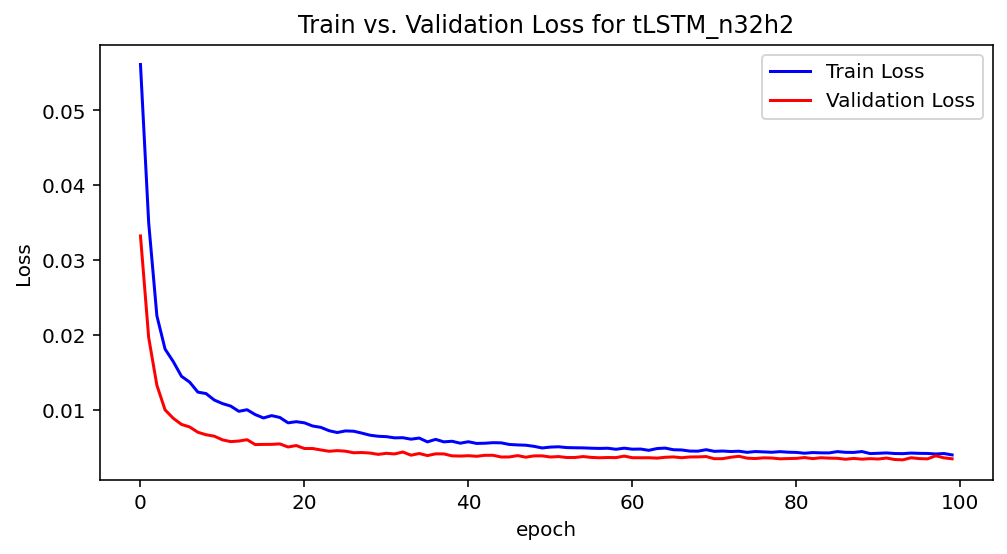

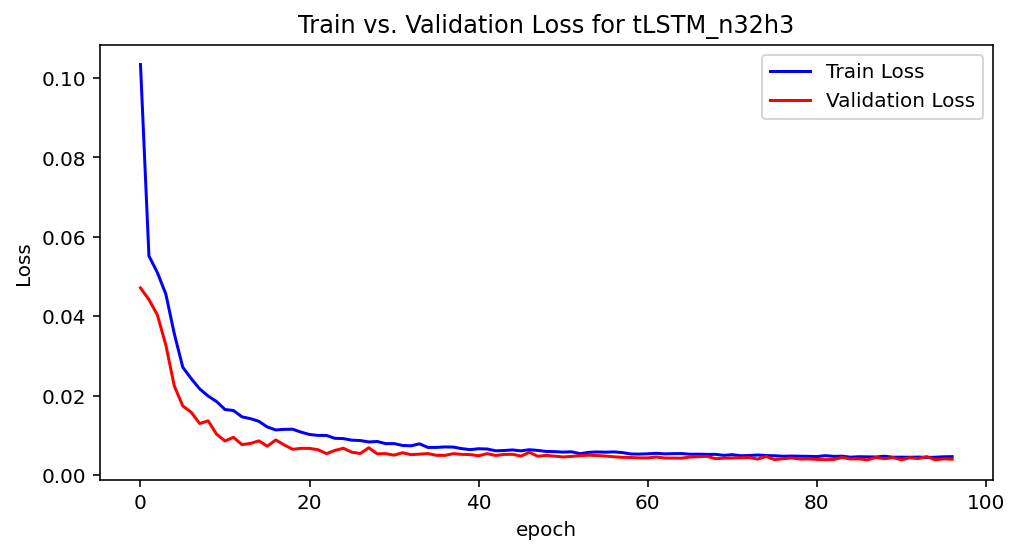

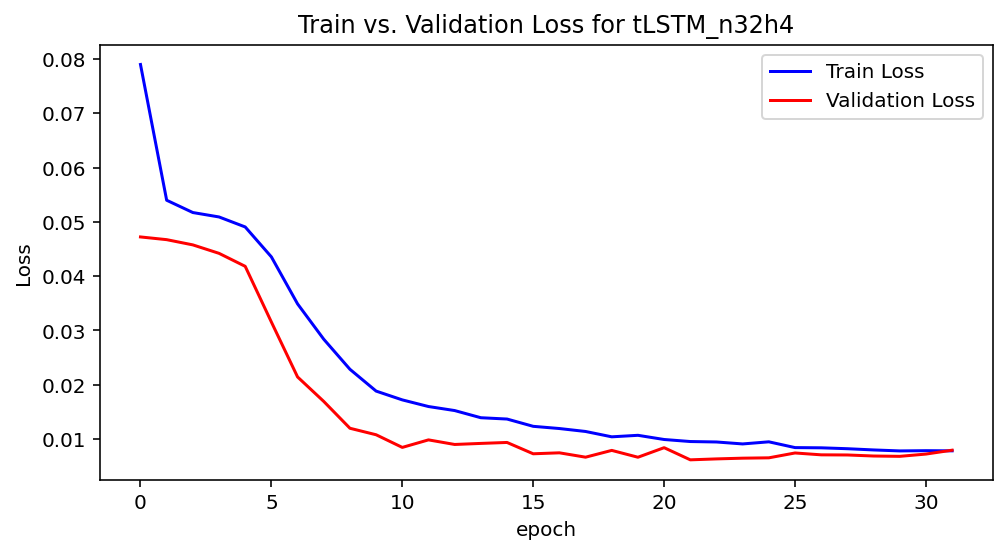

In [61]:
plot_loss(history_tLSTM_n32h2, 'tLSTM_n32h2')
plot_loss(history_tLSTM_n32h3, 'tLSTM_n32h3')
plot_loss(history_tLSTM_n32h4, 'tLSTM_n32h4')
plot_loss(history_GRU_n32, 'GRU_n32')
plot_loss(history_BiLSTM_n32, 'BiLSTM_n32')
plot_loss(history_BiGRU_n32, 'BiGRU_n32')

### Forecast Data

In [125]:
# Calculate predictions neurons
prediction_vLSTM_n4 = prediction(vLSTM_n4, x_test, y_test)
prediction_vLSTM_n8 = prediction(vLSTM_n8, x_test, y_test)
prediction_vLSTM_n16 = prediction(vLSTM_n16, x_test, y_test)
prediction_vLSTM_n32 = prediction(vLSTM_n32, x_test, y_test)

In [ ]:
# Calculate predictions layers
prediction_tLSTM_n32h2 = prediction(tLSTM_n32h2, x_test, y_test)
prediction_tLSTM_n32h3 = prediction(tLSTM_n32h3, x_test, y_test)
prediction_tLSTM_n32h4 = prediction(tLSTM_n32h4, x_test, y_test)
prediction_GRU_n32 = prediction(GRU_n32, x_test, y_test)
prediction_BiLSTM_n32 = prediction(BiLSTM_n32, x_test, y_test)
prediction_BiGRU_n32 = prediction(BiGRU_n32, x_test, y_test)

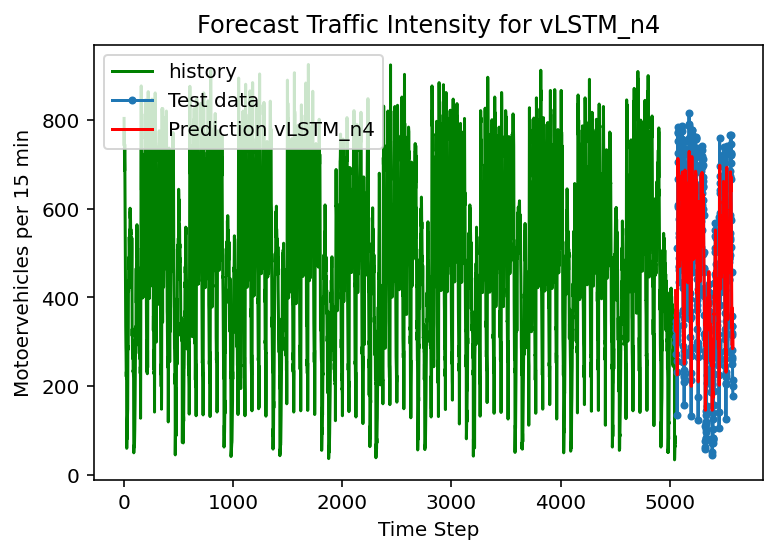

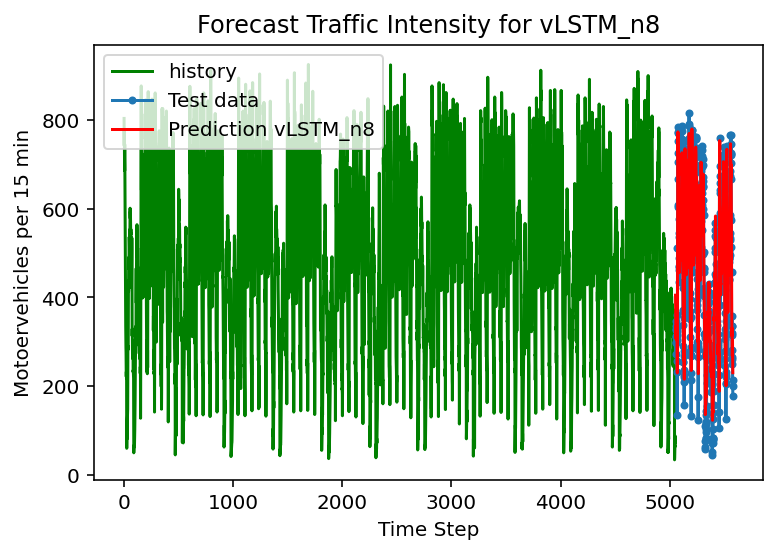

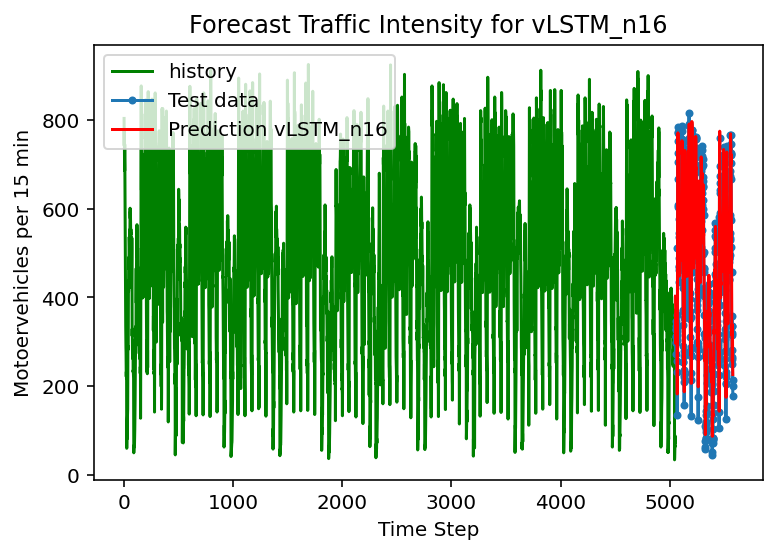

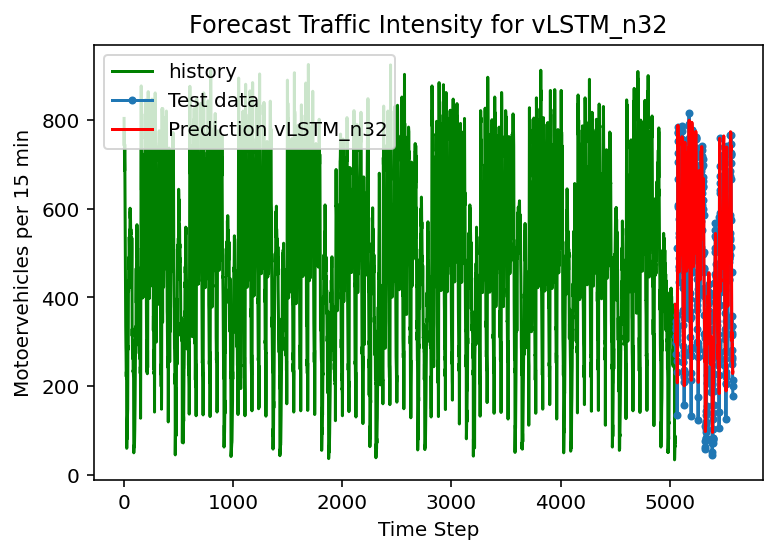

In [126]:
plot_forecast(prediction_vLSTM_n4, y_test, 'vLSTM_n4')
plot_forecast(prediction_vLSTM_n8, y_test, 'vLSTM_n8')
plot_forecast(prediction_vLSTM_n16, y_test, 'vLSTM_n16')
plot_forecast(prediction_vLSTM_n32, y_test, 'vLSTM_n32')

In [ ]:
plot_forecast(prediction_tLSTM_n32h2, y_test, 'tLSTM_n32h2')
plot_forecast(prediction_tLSTM_n32h3, y_test, 'tLSTM_n32h3')
plot_forecast(prediction_tLSTM_n32h4, y_test, 'tLSTM_n32h4')
plot_forecast(prediction_GRU_n32, y_test, 'GRU_n32')
plot_forecast(prediction_BiLSTM_n32, y_test, 'BiLSTM_n32')
plot_forecast(prediction_BiGRU_n32, y_test, 'BiGRU_n32')

### Compare Test vs Prediction

In [ ]:
plot_compare(prediction_vLSTM_n4, y_test, 'vLSTM_n4')
plot_compare(prediction_vLSTM_n8, y_test, 'vLSTM_n8')
plot_compare(prediction_vLSTM_n16, y_test, 'vLSTM_n16')
plot_compare(prediction_vLSTM_n32, y_test, 'vLSTM_n32')

In [ ]:
plot_compare(prediction_tLSTM_n32h2, y_test, 'tLSTM_n32h2')
plot_compare(prediction_tLSTM_n32h3, y_test, 'tLSTM_n32h3')
plot_compare(prediction_tLSTM_n32h4, y_test, 'tLSTM_n32h4')
plot_compare(prediction_GRU_n32, y_test, 'GRU_n32')
plot_compare(prediction_BiLSTM_n32, y_test, 'BiLSTM_n32')
plot_compare(prediction_BiGRU_n32, y_test, 'BiGRU_n32')

### Evaluate Performance

In [ ]:
evaluate_performance(prediction_vLSTM_n4, y_test, 'vLSTM_n4')
evaluate_performance(prediction_vLSTM_n8, y_test, 'vLSTM_n8')
evaluate_performance(prediction_vLSTM_n16, y_test, 'vLSTM_n16')
evaluate_performance(prediction_vLSTM_n32, y_test, 'vLSTM_n32')

In [ ]:
evaluate_performance(prediction_tLSTM_n32h2, y_test, 'tLSTM_n32h2')
evaluate_performance(prediction_tLSTM_n32h3, y_test, 'tLSTM_n32h3')
evaluate_performance(prediction_tLSTM_n32h4, y_test, 'tLSTM_n32h4')
evaluate_performance(prediction_GRU_n32, y_test, 'GRU_n32')
evaluate_performance(prediction_BiLSTM_n32, y_test, 'BiLSTM_n32')
evaluate_performance(prediction_BiGRU_n32, y_test, 'BiGRU_n32')

## 7. Specific Data

Vitesse - AZ 02/04/2019 18.30

In [148]:
df = pd.read_csv('Dataset_processed.csv', index_col=0)
df = df[['Intensity', 'Speed_lane1', 'Speed_lane2', 'Sight']]
df['Date Time'] = pd.to_datetime(df.index, dayfirst=True)
print(df.head())
df = df.reset_index(drop=True)

                  Intensity  Speed_lane1  Speed_lane2  Sight  \
timestamp                                                      
01/02/2019 06:00        102         63.4         60.2     57   
01/02/2019 06:15        135         76.9         67.2     58   
01/02/2019 06:30        266         71.5         60.6     58   
01/02/2019 06:45        411         75.6         64.5     58   
01/02/2019 07:00        596         71.1         62.6     58   

                           Date Time  
timestamp                             
01/02/2019 06:00 2019-02-01 06:00:00  
01/02/2019 06:15 2019-02-01 06:15:00  
01/02/2019 06:30 2019-02-01 06:30:00  
01/02/2019 06:45 2019-02-01 06:45:00  
01/02/2019 07:00 2019-02-01 07:00:00  


In [149]:
date='2019-04-02'
start_test = df[df['Date Time'] ==  date+' 15:30:00'].index[0]
print(df.iloc[[start_test]])
df = df[['Intensity', 'Speed_lane1', 'Speed_lane2', 'Sight']]

      Intensity  Speed_lane1  Speed_lane2  Sight           Date Time
3851        630        104.6         92.2     73 2019-04-02 15:30:00


In [150]:
int(len(df) * (start_test/len(df)))

3851

In [158]:
train_size = int(len(df) * (start_test/len(df)))
test_size = len(df) - start_test
train, event_data = df.iloc[0:start_test-4], df.iloc[start_test-4:len(df)]
print(len(train), len(event_data))

3847 1813


In [159]:
features = ['Speed_lane1', 'Speed_lane2', 'Sight']

feature_scaler = MinMaxScaler()
intensity_scaler = MinMaxScaler()

feature_scaler = feature_scaler.fit(train[features].to_numpy())
intensity_scaler = intensity_scaler.fit(train[['Intensity']])

train.loc[:, features] = feature_scaler.transform(train[features].to_numpy())
train['Intensity'] = intensity_scaler.transform(train[['Intensity']])

test.loc[:, features] = feature_scaler.transform(test[features].to_numpy())
test['Intensity'] = intensity_scaler.transform(test[['Intensity']])

/Users/willekes/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-159-89f294edac0e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Intensity'] = intensity_scaler.transform(train[['Intensity']])
/Users/willekes/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docum

In [175]:
x_event_train, y_event_train = training_data(train, train.Intensity, 40)
x_event_test, y_event_test = training_data(event_data, event_data.Intensity, 40)
print(x_event_train.shape, y_event_train.shape)
print(x_event_test.shape, y_event_test.shape)

(3807, 40, 4) (3807,)
(1773, 40, 4) (1773,)


In [176]:
event_vLSTM_n32 = model_vLSTM(32)
event_BiLSTM_n32 = model_BiLSTM(32)
event_BiGRU_n32 = model_BiGRU(32)

In [177]:
history_event_vLSTM_n32 = fit_model(event_vLSTM_n32)
#history_event_BiLSTM_n32 =fit_model(event_BiLSTM_n32)
history_event_BiGRU_n32 = fit_model(event_BiGRU_n32)

Epoch 1/100
72/72 [==============================] - 2s 16ms/step - loss: 0.0598 - val_loss: 0.0207
Epoch 2/100
72/72 [==============================] - 1s 14ms/step - loss: 0.0295 - val_loss: 0.0142
Epoch 3/100
72/72 [==============================] - 1s 14ms/step - loss: 0.0216 - val_loss: 0.0100
Epoch 4/100
72/72 [==============================] - 1s 14ms/step - loss: 0.0167 - val_loss: 0.0078
Epoch 5/100
72/72 [==============================] - 1s 15ms/step - loss: 0.0144 - val_loss: 0.0072
Epoch 6/100
72/72 [==============================] - 1s 17ms/step - loss: 0.0132 - val_loss: 0.0065
Epoch 7/100
72/72 [==============================] - 1s 14ms/step - loss: 0.0122 - val_loss: 0.0061
Epoch 8/100
72/72 [==============================] - 1s 14ms/step - loss: 0.0117 - val_loss: 0.0057
Epoch 9/100
72/72 [==============================] - 1s 14ms/step - loss: 0.0108 - val_loss: 0.0055
Epoch 10/100
72/72 [==============================] - 1s 14ms/step - loss: 0.0107 - val_loss: 0.0051

72/72 [==============================] - 1s 15ms/step - loss: 0.0048 - val_loss: 0.0033
Epoch 83/100
72/72 [==============================] - 1s 15ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 84/100
72/72 [==============================] - 1s 14ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 85/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0045 - val_loss: 0.0034
Epoch 86/100
72/72 [==============================] - 1s 16ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 87/100
72/72 [==============================] - 1s 15ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 88/100
72/72 [==============================] - 1s 15ms/step - loss: 0.0048 - val_loss: 0.0035
Epoch 89/100
72/72 [==============================] - 1s 14ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 90/100
72/72 [==============================] - 1s 15ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 91/100
72/72 [==============================] - 1s 15ms/step - loss: 0.0047 - val_loss: 0.0034
Epo

72/72 [==============================] - 2s 21ms/step - loss: 0.0049 - val_loss: 0.0034
Epoch 64/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0048 - val_loss: 0.0035
Epoch 65/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0047 - val_loss: 0.0035
Epoch 66/100
72/72 [==============================] - 1s 20ms/step - loss: 0.0047 - val_loss: 0.0035
Epoch 67/100
72/72 [==============================] - 1s 20ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 68/100
72/72 [==============================] - 2s 28ms/step - loss: 0.0047 - val_loss: 0.0035
Epoch 69/100
72/72 [==============================] - 2s 25ms/step - loss: 0.0047 - val_loss: 0.0034
Epoch 70/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0047 - val_loss: 0.0034
Epoch 71/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 72/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0046 - val_loss: 0.0034
Epo

In [179]:
prediction_event_vLSTM_n32 = prediction(event_vLSTM_n32, x_event_test, y_event_test)
#prediction_event_BiLSTM_n32 = prediction(event_BiLSTM_n32, x_event_test, y_event_test)
prediction_event_BiGRU_n32 = prediction(event_BiGRU_n32, x_event_test, y_event_test)

In [180]:
def event_plot_compare(prediction_model_1, prediction_model_2, y_test, model_name_1, model_name_2):
    
    y_pred_1, y_pred_inv_1, y_train_inv_1, y_test_inv_1 = prediction_model_1
    y_pred_2, y_pred_inv_2, y_train_inv_2, y_test_inv_2 = prediction_model_2

    
    
    test_data = y_test.reshape(-1,1)
    plt.plot(test_data[:4].flatten(), marker='.', label="Test data")
    
    plt.plot(y_pred_1[:4].flatten(), 'red', label="Prediction "+model_name_1)
    plt.plot(y_pred_2[:4].flatten(), 'green', label="Prediction "+model_name_2)
    
    plt.ylabel('Motorvehicles per 15 min')
    plt.xlabel('Time Step')
    plt.title('Traffic Intensity Forecast for Vitesse-AZ (2/4/19)')
    plt.legend()
    plt.savefig('Models/n/Test vs Prediction/'+'Vitesse-AZ.jpg', format='jpg', dpi=1000)
    plt.show();

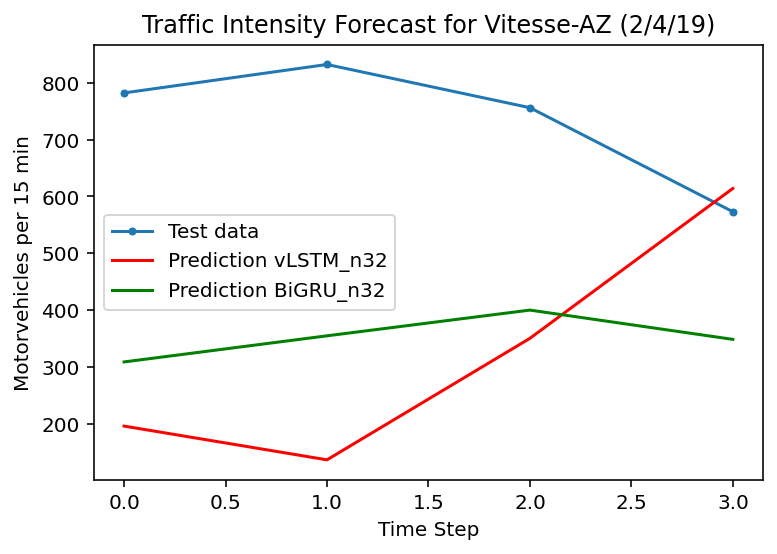

In [181]:
event_plot_compare(prediction_event_vLSTM_n32, prediction_event_BiGRU_n32 , y_event_test, 'vLSTM_n32', 'BiGRU_n32')

In [182]:
def event_evaluate_performance(prediction_model, y_test, model_name):
    y_pred, y_pred_inv, y_train_inv, y_test_inv = prediction_model
    
    
    errors = y_pred[:4] - y_test[:4]
    
    mae = round(np.abs(errors).mean(),2)
    mse = round(np.square(errors).mean(),2)
    rmse = round(np.sqrt(mse),2)
    
    performance = pd.DataFrame({"Model": [model_name], "MAE": [mae], "MSE": [mse], "RMSE": [mse]})
    performance.to_csv('Models/n/Measures/'+'Measures_'+model_name+'.csv')
    
    print('Performance of '+model_name+ ':')
    print('MAE:\t', mae)
    print('MSE:\t', mse)
    print('RMSE:\t', rmse)
    return mae, mse, rmse

In [183]:
event_evaluate_performance(prediction_event_vLSTM_n32, y_event_test, 'event_vLSTM_n32')

Performance of event_vLSTM_n32:
MAE:	 416.75
MSE:	 213100.06
RMSE:	 461.63


(416.75, 213100.06, 461.63)

In [184]:
event_evaluate_performance(prediction_event_BiGRU_n32, y_event_test, 'event_BiGRU_n32')

Performance of event_BiGRU_n32:
MAE:	 382.82
MSE:	 157170.39
RMSE:	 396.45


(382.82, 157170.39, 396.45)